# Clasificador de tejido sano y tejido cancerígeno en imagenes microscópicas del esófago

![image.png](https://drive.google.com/uc?id=1K_j4CnOJeOmiROBiFwEW1M-kJkizrMk7)

## Paso 1. Cargar librerías y módulos requerdidos

In [ ]:
import os            #módulo para manejar carpetas y archivos en nuestro ordenador
import random        #módulo para aleatorizar

import numpy as np   #librería para manejar matrices y operaciones de matrices 
import pandas as pd  #librería para manejar tablas de datos


                                       #Skimage (Scikit-image): librería para procesamiento de imagenes
from skimage import io                 #Modulo para leer una imagen (librería para procesamiento de imagenes)
#from skimage.transform import rescale  #Función dentro del modulo transform, para cambiar el tamaño de una imagen 


                                                       #Sklearn (Scikit-learn): librería para machine learning 
from sklearn.model_selection import train_test_split   
from sklearn.linear_model import Perceptron 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt        #Para graficar y visualizar
import seaborn as sns


# para especificar que queremos las graficas en linea sin necesidad de usar plt.show()
%matplotlib inline      

## Paso 2. Lectura de datos. 

### 2.1 Lectura de etiquetas (Y)

In [ ]:
#Leemos los datos

datos = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/ClassificadorCancerEsofago/master/ClasesImagenes.csv', usecols=[1,2])

In [ ]:
datos.head()  #muestra los primeros cinco registros

,image_filename,class_number
0,im_4_0.png,0
1,im_21_0.png,0
2,im_9_0.png,0
3,im_8_0.png,0
4,im_15_0.png,0


In [ ]:
#¿Con cuántas imagenes vamos a trabajar?

datos.shape[0]

5063

In [ ]:
#¿cuántas imagenes tenemos de cada clase?

datos['class_number'].value_counts(sort=False)  

0    1469
1    3594
Name: class_number, dtype: int64

Clase 0 corresponde a tejido sano y Clase 1 a tejido Cancerígeno

In [ ]:
Y = datos['class_number']  #Guardamos las etiquetas de las imagenes como serie de pandas


### 2.2 Lectura de imágenes (X)

**Lo primero que tenemos que hacer es descomprimir el archivo zip que guardamos en nuestro dirve**

In [ ]:

#!unzip -u "/content/drive/MyDrive/Datos/DatosCancer/CarpetaImagenes.zip" -d "/content/drive/MyDrive/Datos/DatosCancer/Unzip"


**Al nombre de las imagenes que están en la primera columna de nuestro dataframe  ```datos``` necesitamos añadirle la ruta del directorio en el que se encuentran las imagenes descomprimidas**

In [ ]:
datos.head()

,image_filename,class_number
0,/content/drive/MyDrive/Datos/DatosCancer/Unzip...,0
1,/content/drive/MyDrive/Datos/DatosCancer/Unzip...,0
2,/content/drive/MyDrive/Datos/DatosCancer/Unzip...,0
3,/content/drive/MyDrive/Datos/DatosCancer/Unzip...,0
4,/content/drive/MyDrive/Datos/DatosCancer/Unzip...,0


In [ ]:
ruta = "/content/drive/MyDrive/Datos/DatosCancer/Unzip"

datos['image_filename'] = datos['image_filename'].apply(lambda x: os.path.join(ruta, x))

datos.head(3)

,image_filename,class_number
0,/content/drive/MyDrive/Datos/DatosCancer/Unzip...,0
1,/content/drive/MyDrive/Datos/DatosCancer/Unzip...,0
2,/content/drive/MyDrive/Datos/DatosCancer/Unzip...,0


In [ ]:
for i in range(5):
  print(i, datos['image_filename'][i])

0 /content/drive/MyDrive/Datos/DatosCancer/Unzip/im_4_0.png
1 /content/drive/MyDrive/Datos/DatosCancer/Unzip/im_21_0.png
2 /content/drive/MyDrive/Datos/DatosCancer/Unzip/im_9_0.png
3 /content/drive/MyDrive/Datos/DatosCancer/Unzip/im_8_0.png
4 /content/drive/MyDrive/Datos/DatosCancer/Unzip/im_15_0.png


In [ ]:
%%time
img = datos['image_filename'].apply(lambda x: io.imread(x, as_gray=True))

CPU times: user 38.2 s, sys: 5.36 s, total: 43.6 s
Wall time: 16min 16s


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Cargamos las imagenes del conjunto d entrenamiento como lista de matrices (np.arrays)
# (10 min ultima vez corrido en colab)

#%time img= [io.imread(i, as_gray=True) for i in datos['image_filename'][:]]

In [ ]:
img[1].shape   # dimensión 67,200

(260, 260)

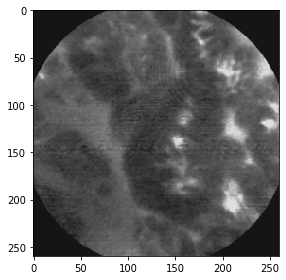

In [ ]:
io.imshow(img[500]) 

- Dimensión 0: 260 renglones de pixeles de arriba a abajo
- Dimensión 1: 260 columnas de pixeles de izquierda a derecha


####  Transformar imágenes en vectores
Lo primero es transformar la secuencia img en una matriz


In [ ]:
img.values[0].shape

(260, 260)

In [ ]:
IMG = np.stack(img, axis=0)  # Toma una secuencia de matrices y las apila a lo largo 
                              # de un tercer eje para hacer una sola matriz              
IMG.shape

(5063, 260, 260)

Despues aplanar la matriz de 2D (260x260 pixeles) de cada imagen, para obtener un vector por imagen. 

In [ ]:
X = IMG.reshape(5063, -1)
X.shape

(5063, 67600)

##### Visualizamos ejemplos de ambas clases de imagenes

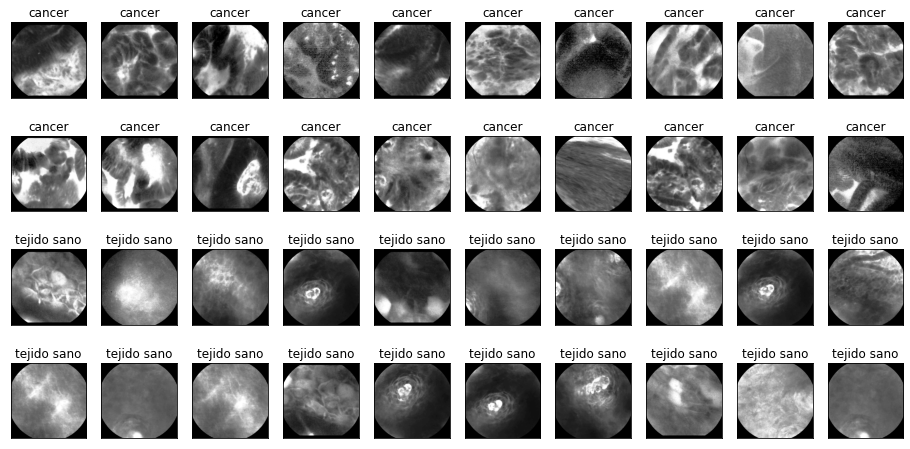

In [ ]:
#El método GroupBy de Pandas separa un data frame en varios data frames
porClase = datos.groupby('class_number')

#elije al azar n muestras de cada subconjunto y guarda la posición de las figuras elegidas en una lista
n = 20
c = random.sample(porClase.get_group(1).index.tolist(), n) # indices de las imagenes cancerígenas seleccionadas
s = random.sample(porClase.get_group(0).index.tolist(), n) # indices de las imagenes sanas seleccionadas

# Grafica 20 imágenes aleatorias de tejido con cáncer y 20 de tejido sano

fig=plt.figure(figsize=(16, 8))
columns = 10
rows = 4
for i in range(0, columns * rows):
    fig.add_subplot( rows, columns, i+1)
    if i < 20:
        plt.imshow(img[c[i]], cmap='Greys_r')
        plt.title('cancer')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow(img[s[i-20]], cmap='Greys_r')
        plt.title('tejido sano')
        plt.xticks([])
        plt.yticks([])
plt.show()

## Paso 3. Entrenamiento utilizando perceptrón simple con conjunto de entrenamiento y prueba

### 3.1  Crear subconjuntos de entrenamiento y prueba



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, 
                                                    shuffle=True, random_state=0)

In [ ]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Training set")
print("X: ", X_train.shape)
print("Y: ", y_train.shape)
unique, counts= np.unique(y_train, return_counts=True)
print('Tejido Sano:        ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')


print("Test set")
print("X: ", X_test.shape)
print("Y: ", y_test.shape)
unique, counts= np.unique(y_test, return_counts=True)
print('Tejido Sano:         ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')

Training set
X:  (3544, 67600)
Y:  (3544,)
Tejido Sano:         1043 
Displasia o Cáncer:  2501 

Test set
X:  (1519, 67600)
Y:  (1519,)
Tejido Sano:          426 
Displasia o Cáncer:  1093 



### 3.2  Entrenamiento



In [ ]:
model = Perceptron(max_iter=1000,  random_state=0) 
model.fit(X_train,y_train)                                  

print("Iterations: ", model.n_iter_)

Iterations:  44


In [ ]:
#Guardamos los coeficientes del modelo como beta

beta=model.coef_
print(beta.shape)

(1, 67600)


In [ ]:
beta[0, 50310:50320]

array([ -1.92002706,  26.43550275,  48.33832196,  60.5412651 ,
        36.79920392,  20.46658157,  -2.35208118, -16.18895686,
       -16.80207686,   4.81493412])

In [ ]:
y_predict=model.predict(X_test)  #pasa cada una de las imágenes de X_test por el modelo 

In [ ]:
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_predict)*100))

Accuracy: 90.19%


In [ ]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 95.49%
Precisión conjunto prueba: 90.19%


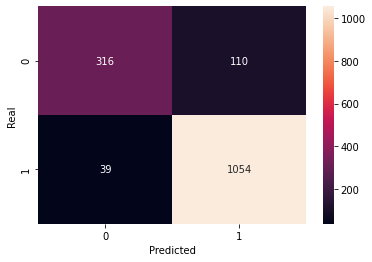

In [ ]:
#Matriz de confusión

data = {'Y_Real':  y_test,
        'Y_Prediccion':y_predict
        }

df = pd.DataFrame(data, columns=['Y_Real','Y_Prediccion'])
confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Prediccion'], rownames=['Real'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

## Paso 4. Entrenamiento de perceptron utilizando margen

In [ ]:
model2 = Perceptron(max_iter=1000,  random_state=0, penalty='l2',  alpha=0.0001) 
model2.fit(X_train,y_train)                                  

print("Precisión conjunto entrenamiento: %.2f%%" % (model2.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model2.score(X_test, y_test)*100.0))


Precisión conjunto entrenamiento: 77.48%
Precisión conjunto prueba: 77.49%


In [ ]:
model2 = Perceptron(max_iter=1000,  random_state=0, penalty='l2', alpha=0.000005) 
model2.fit(X_train,y_train)                                  

print("Precisión conjunto entrenamiento: %.2f%%" % (model2.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model2.score(X_test, y_test)*100.0))


Precisión conjunto entrenamiento: 94.38%
Precisión conjunto prueba: 90.06%


In [ ]:
model2 = Perceptron(max_iter=1000,  random_state=0, penalty='l2', alpha=0.000001) 
model2.fit(X_train,y_train)                                  

print("Precisión conjunto entrenamiento: %.2f%%" % (model2.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model2.score(X_test, y_test)*100.0))


Precisión conjunto entrenamiento: 98.59%
Precisión conjunto prueba: 92.03%
